# Observational study 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotnine
import networkx as nx
from plotnine import ggplot, aes, geom_bar
from functions import *
import statsmodels.formula.api as smf
import spacy
import time
import datetime
import yfinance as yf

In [2]:
from popularity import trending_history
from financials import *

In [3]:
data = pd.read_csv('data/FinalFeatures.csv.bz2')

In [4]:
data

,Name,Date,Close,Volume,MarketCap,Popularity,Elon,compare,Money Volume
0,Microsoft,2015-02-05,37.361660,34616600.0,2.805106e+11,30,0,Apple,1.293334e+09
1,IBM,2015-02-05,111.899734,3406299.0,1.002980e+11,4,0,Apple,3.811640e+08
2,Samsung,2015-02-05,23147.439453,8005050.0,1.381851e+14,100,0,Apple,1.852964e+11
3,Lenovo,2015-02-05,20.973969,57300.0,1.262811e+10,17,0,Apple,1.201808e+06
4,Apple,2015-02-05,27.025124,174826400.0,4.433850e+11,39,1,None,4.724705e+09
...,...,...,...,...,...,...,...,...,...
4665,Rivian,2020-04-16,100.730003,103679500.0,8.898488e+10,1,0,Tesla,1.044364e+10
4666,Lucid,2020-04-16,9.890000,564300.0,1.628260e+10,9,0,Tesla,5.580927e+06
4667,VolksWagen,2020-04-16,117.395164,2322531.0,2.420747e+10,61,0,Tesla,2.726539e+08
4668,General Motors,2020-04-16,22.480000,17166300.0,3.263781e+10,2,0,Tesla,3.858984e+08


In [5]:
#samsungs marketCap is off by 1000x, we checked yahoo finance and there its off by 1000x as well, 
#... after lots of reading we found out that the stock price is in Korean Won
#Korean Won has hovered around 1000 per dollar for the time period we operate in so we will devide by that amount
data['MarketCap'] = np.where(data['Name'] == 'Samsung', data['MarketCap']/1000, data['MarketCap'])
data['MarketCap'] = np.where(data['Name'] == 'Samsung', data['Money Volume']/1000, data['Money Volume'])
data

,Name,Date,Close,Volume,MarketCap,Popularity,Elon,compare,Money Volume
0,Microsoft,2015-02-05,37.361660,34616600.0,1.293334e+09,30,0,Apple,1.293334e+09
1,IBM,2015-02-05,111.899734,3406299.0,3.811640e+08,4,0,Apple,3.811640e+08
2,Samsung,2015-02-05,23147.439453,8005050.0,1.852964e+08,100,0,Apple,1.852964e+11
3,Lenovo,2015-02-05,20.973969,57300.0,1.201808e+06,17,0,Apple,1.201808e+06
4,Apple,2015-02-05,27.025124,174826400.0,4.724705e+09,39,1,None,4.724705e+09
...,...,...,...,...,...,...,...,...,...
4665,Rivian,2020-04-16,100.730003,103679500.0,1.044364e+10,1,0,Tesla,1.044364e+10
4666,Lucid,2020-04-16,9.890000,564300.0,5.580927e+06,9,0,Tesla,5.580927e+06
4667,VolksWagen,2020-04-16,117.395164,2322531.0,2.726539e+08,61,0,Tesla,2.726539e+08
4668,General Motors,2020-04-16,22.480000,17166300.0,3.858984e+08,2,0,Tesla,3.858984e+08


## Matching : 

In [6]:
#Propensity score : 
def add_propensityscore (data):#so that if we want to change only the first line don't have to do it
    #With a column of one and zero if elon musk talked about you 
    #company = company_quote.extend(controled)
    #data = compareCompanies(company,date)
    #Normalise the features 
    data['Close'] = (data['Close'] - data['Close'].mean())/data['Close'].std()
    data['Volume']= (data['Volume']-data['Volume'].mean())/data['Volume'].std()
    data['Money Volume']= (data['Money Volume']-data['Money Volume'].mean())/data['Money Volume'].std()
    data['MarketCap']= (data['MarketCap']-data['MarketCap'].mean())/data['MarketCap'].std()
    data['Popularity']= (data['Popularity']-data['Popularity'].mean())/data['Popularity'].std()
    #Create the model
    mod = smf.logit(formula='Elon ~ Money Volume + MarketCap + Popularity', data=data)
    res = mod.fit()
    data['Propensity_score'] = res.predict()

In [7]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [8]:
def matchingfunction(data):
    treatment_df = data[data['Elon'] == 1]
    control_df   = data[data['Elon'] == 0]
    # Create an empty undirected graph
    G = nx.Graph()
    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            if (control_row['compare']== treatment_row['Name']) and (control_row['Date']== treatment_row['Date']) :
                # Calculate the similarity 
                similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])
                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])
    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    return matching

In [9]:
add_propensityscore(data)

         Current function value: 0.114130
         Iterations: 35


C:\Users\Ferdi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
C:\Users\Ferdi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


In [10]:
data

,Name,Date,Close,Volume,MarketCap,Popularity,Elon,compare,Money Volume,Propensity_score
0,Microsoft,2015-02-05,-0.106360,0.084054,-0.296528,-0.172149,0,Apple,-0.088495,3.154527e-01
1,IBM,2015-02-05,-0.081014,-0.645759,-0.515278,-0.789102,0,Apple,-0.106240,6.295556e-08
2,Samsung,2015-02-05,7.752008,-0.538223,-0.562250,1.488877,0,Apple,3.491127,0.000000e+00
3,Lenovo,2015-02-05,-0.111933,-0.724072,-0.606398,-0.480625,0,Apple,-0.113632,4.434291e-02
4,Apple,2015-02-05,-0.109875,3.362684,0.526361,0.041411,1,None,-0.021740,9.999858e-01
...,...,...,...,...,...,...,...,...,...,...
4665,Rivian,2020-04-16,-0.084812,1.699003,1.897837,-0.860289,0,Tesla,0.089517,7.788482e-03
4666,Lucid,2020-04-16,-0.115702,-0.712216,-0.605348,-0.670457,0,Tesla,-0.113547,5.876749e-02
4667,VolksWagen,2020-04-16,-0.079145,-0.671102,-0.541300,0.563448,0,Tesla,-0.108351,1.309028e-04
4668,General Motors,2020-04-16,-0.111420,-0.323999,-0.514143,-0.836560,0,Tesla,-0.106148,1.223647e-02


In [11]:
b = matchingfunction(data)

In [12]:
b

{(0, 4),
 (9, 5),
 (10, 14),
 (19, 15),
 (24, 20),
 (25, 29),
 (34, 30),
 (35, 39),
 (40, 44),
 (49, 45),
 (50, 54),
 (59, 55),
 (64, 60),
 (68, 69),
 (73, 74),
 (78, 79),
 (83, 84),
 (89, 85),
 (93, 94),
 (99, 95),
 (104, 103),
 (108, 109),
 (113, 114),
 (118, 119),
 (120, 124),
 (128, 129),
 (133, 134),
 (138, 139),
 (144, 143),
 (148, 149),
 (153, 154),
 (158, 159),
 (163, 164),
 (168, 169),
 (173, 174),
 (178, 179),
 (184, 183),
 (188, 189),
 (193, 194),
 (198, 199),
 (203, 204),
 (208, 209),
 (213, 214),
 (218, 219),
 (224, 221),
 (227, 229),
 (232, 234),
 (237, 239),
 (243, 244),
 (249, 246),
 (251, 254),
 (256, 259),
 (264, 261),
 (266, 269),
 (274, 271),
 (276, 279),
 (280, 284),
 (288, 289),
 (291, 294),
 (296, 299),
 (304, 301),
 (306, 309),
 (314, 311),
 (317, 319),
 (323, 324),
 (329, 326),
 (331, 334),
 (336, 339),
 (344, 341),
 (345, 349),
 (354, 350),
 (356, 359),
 (362, 364),
 (369, 366),
 (371, 374),
 (378, 379),
 (384, 383),
 (388, 389),
 (393, 394),
 (398, 399),
 (40

In [141]:
tesla_match = []
apple_match = []
twitter_match = []
ford_match = []
paypal_match = []
for pair in b:
    l = (data.iloc[int(pair[0])].Name, data.iloc[int(pair[1])].Name, data.iloc[int(pair[0])]['Date'])
    if 'Tesla' in l:
        tesla_match.append(l)
    elif 'Apple' in l:
        apple_match.append(l)
    elif 'Twitter' in l:
        twitter_match.append(l)
    elif 'Ford' in l:
        ford_match.append(l)
    elif 'Paypal' in l:
        paypal_match.append(l)
apple_match[0:8]

[('Apple', 'Microsoft', '2015-05-14'),
 ('Lenovo', 'Apple', '2015-10-10'),
 ('Lenovo', 'Apple', '2016-06-30'),
 ('Apple', 'Lenovo', '2017-02-05'),
 ('Apple', 'Microsoft', '2015-02-24'),
 ('Apple', 'Microsoft', '2015-10-20'),
 ('Microsoft', 'Apple', '2015-02-21'),
 ('Lenovo', 'Apple', '2017-08-04')]

In [142]:
tesla_match[0:8]

[('Lucid', 'Tesla', '2017-09-30'),
 ('VolksWagen', 'Tesla', '2017-08-09'),
 ('Lucid', 'Tesla', '2019-04-21'),
 ('Tesla', 'Lucid', '2015-10-13'),
 ('VolksWagen', 'Tesla', '2015-10-15'),
 ('Tesla', 'Lucid', '2018-05-21'),
 ('Lucid', 'Tesla', '2018-07-23'),
 ('Lucid', 'Tesla', '2020-02-17')]

In [ ]:
def stock_history(company_name, start_date, end_date, plot=False):
    ticker = ticker_of_company(company_name)
    company = yf.Ticker(ticker)
    
    df = company.history(start=start_date, end=end_date)[['Close', 'Volume']]
    numberOfShares = company.info['sharesOutstanding']
    
    df['MarketCap'] = numberOfShares*df['Close']
    
    return df

In [16]:
first_date = data.iloc[0]['Date']

In [104]:
tesla_c = {'Tesla' : stock_history('Tesla', first_date, '2021-01-01'),
            'Rivian' : stock_history('Rivian', first_date, '2021-01-01'),
            'Lucid' : stock_history('Lucid', first_date, '2021-01-01'),
            'VolksWagen' : stock_history('VolksWagen', first_date, '2021-01-01'),
            'General Motors' : stock_history('General Motors', first_date, '2021-01-01')}

- RIVN: Data doesn't exist for startDate = 1423090800, endDate = 1609455600


In [116]:
stock_history('Rivian', first_date, '2021-01-01')

- RIVN: Data doesn't exist for startDate = 1423090800, endDate = 1609455600


,Close,Volume,MarketCap
Date,,,


In [105]:
apple_c = {'Apple' : stock_history('Apple', first_date, '2021-01-01'),
            'IBM' : stock_history('IBM', first_date, '2021-01-01'),
            'Samsung' : stock_history('Samsung', first_date, '2021-01-01'),
            'Lenovo' : stock_history('Lenovo', first_date, '2021-01-01'),
            'Microsoft' : stock_history('Microsoft', first_date, '2021-01-01')}

In [118]:
twitter_c = {'Twitter' : stock_history('Twitter', first_date, '2021-01-01'),
            'Google' : stock_history('Google', first_date, '2021-01-01'),
            'Facebook' : stock_history('Facebook', first_date, '2021-01-01'),
            'Snapchat' : stock_history('Snapchat', first_date, '2021-01-01'),
            'Pinterest' : stock_history('Pinterest', first_date, '2021-01-01')}

In [127]:
stock_history('Pinterest', first_date, '2021-01-01')

,Close,Volume,MarketCap
Date,,,
2019-04-18,24.400000,87109500,1.372988e+10
2019-04-22,24.990000,19746800,1.406187e+10
2019-04-23,25.850000,19245400,1.454580e+10
2019-04-24,26.799999,9477200,1.508036e+10
2019-04-25,28.799999,16648300,1.620576e+10
...,...,...,...
2020-12-24,71.040001,4552300,3.997421e+10
2020-12-28,67.790001,8081200,3.814544e+10
2020-12-29,68.290001,6939400,3.842679e+10


In [119]:
ford_c = {'Ford' : stock_history('Ford', first_date, '2021-01-01'),
            'Toyota' : stock_history('Toyota', first_date, '2021-01-01'),
            'BMW' : stock_history('BMW', first_date, '2021-01-01'),
            'General Motors' : stock_history('General Motors', first_date, '2021-01-01'),
            'Stellantis' : stock_history('Stellantis', first_date, '2021-01-01')}

In [120]:
paypal_c = {'PayPal' : stock_history('PayPal', first_date, '2021-01-01'),
            'Western Union' : stock_history('Western Union', first_date, '2021-01-01'),
            'EuroNet' : stock_history('EuroNet', first_date, '2021-01-01'),
            'MoneyGram' : stock_history('MoneyGram', first_date, '2021-01-01'),
            'Payoneer' : stock_history('Payoneer', first_date, '2021-01-01')}

In [139]:
stock_history('Payoneer', first_date, '2021-01-01').head(5)

,Close,Volume,MarketCap
Date,,,
2020-10-16,9.68,1151400,3.281598e+09
2020-10-19,9.69,2900,3.284987e+09
2020-10-20,9.80,2300,3.322278e+09
2020-10-21,9.65,86100,3.271427e+09
2020-10-22,9.64,78500,3.268037e+09


In [109]:
def hist_from_hist(hist, start_date, end_date):
    internal_np = []
    for i in range(len(hist)):
        if hist.iloc[i].name.date() < datetime.date.fromisoformat(start_date):
            start = i
        if hist.iloc[i].name.date() > datetime.date.fromisoformat(end_date):
            end = i-1
            break
    return hist.copy().iloc[start:end]
def get_dates_c(start_date, weeks, days):
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = start_date + dt.timedelta(weeks=weeks, days=days)
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
def dailyChangeC(hist, start_date, end_date):
    df = hist_from_hist(hist, start_date, end_date)
    result = []
    for i in range(len(df)-1):
        changeFromPreviousDay = 1-(df.iloc[i+1]['Close']/df.iloc[i]['Close'])
        result.append(float(changeFromPreviousDay))
    return result
#dailyChangeIndex(companies, start_date, end_date)

In [110]:
days = 5

In [111]:
def change_distributions(company_match, company_c):
    co = {[*company_c.keys()][0] : {'x' : [], 'y' : []},
         [*company_c.keys()][1] : {'x' : [], 'y' : []},
         [*company_c.keys()][2] : {'x' : [], 'y' : []},
         [*company_c.keys()][3] : {'x' : [], 'y' : []},
         [*company_c.keys()][4] : {'x' : [], 'y' : []}}

    for i in range(len(company_match)):
        dates = get_dates_c(company_match[i][2], 0, days)
        #if apple_match[i][0] == [*apple_c.keys()][4]:
        comp1 = company_match[i][0]
        temp = dailyChangeC(company_c[comp1], dates[0], dates[1])
        co[comp1]['x'].extend(temp)
        co[comp1]['y'].extend([*range(len(temp))])

        comp2 = company_match[i][1]
        temp = dailyChangeC(company_c[comp2], dates[0], dates[1])
        co[comp2]['x'].extend(temp)
        co[comp2]['y'].extend([*range(len(temp))])

    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(15,5))
    ax1.scatter([*co.values()][0]['y'], [*co.values()][0]['x'])
    ax1.set_title([*co.keys()][0])
    ax2.scatter([*co.values()][1]['y'], [*co.values()][1]['x'], label=[*co.keys()][1])
    ax2.set_title([*co.keys()][1])
    ax3.scatter([*co.values()][2]['y'], [*co.values()][2]['x'], label=[*co.keys()][2])
    ax3.set_title([*co.keys()][2])
    ax4.scatter([*co.values()][3]['y'], [*co.values()][3]['x'], label=[*co.keys()][3])
    ax4.set_title([*co.keys()][3])
    ax5.scatter([*co.values()][4]['y'], [*co.values()][4]['x'], label=[*co.keys()][4])
    ax5.set_title([*co.keys()][4])

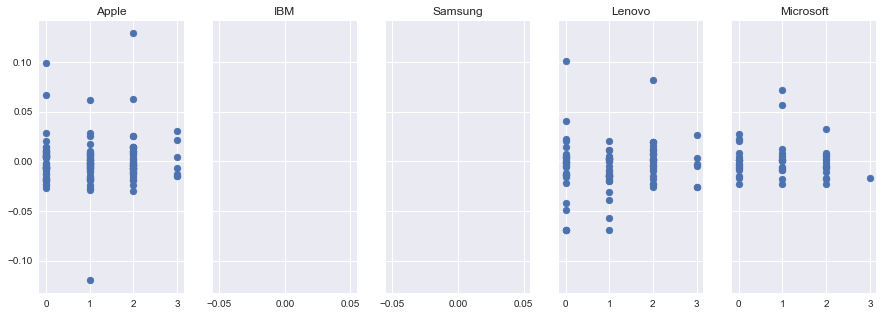

In [112]:
change_distributions(apple_match, apple_c)

In [143]:
change_distributions(twitter_match, twitter_c)

UnboundLocalError: local variable 'start' referenced before assignment

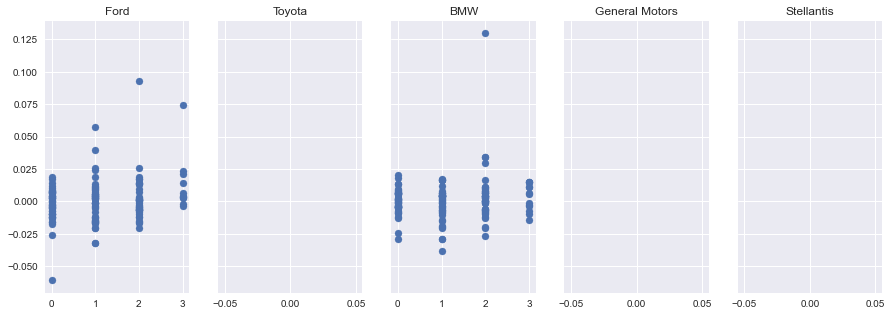

In [114]:
change_distributions(ford_match, ford_c)

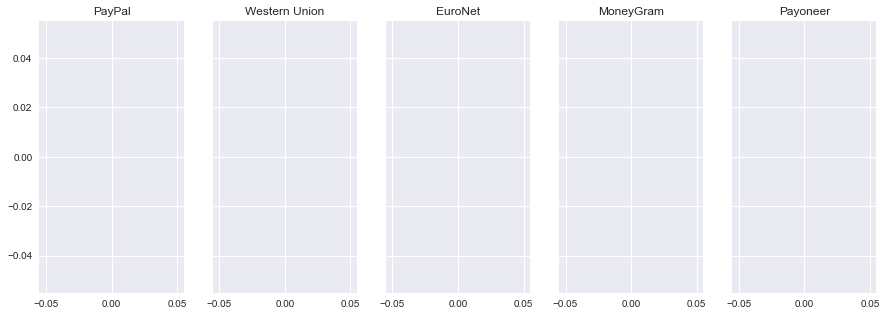

In [145]:
change_distributions(paypal_match, paypal_c)